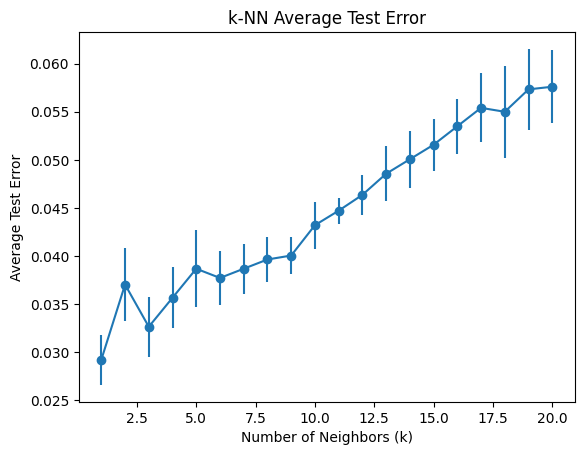

Optimal k: 1
Confusion Matrix:
[[355   0   2   0   0   0   0   1   0   1]
 [  0 255   0   0   6   0   2   1   0   0]
 [  6   1 183   2   1   0   0   2   3   0]
 [  3   0   2 154   0   5   0   0   0   2]
 [  0   3   1   0 182   1   2   2   1   8]
 [  2   1   2   4   0 145   2   0   3   1]
 [  0   0   1   0   2   3 164   0   0   0]
 [  0   1   1   1   4   0   0 139   0   1]
 [  5   0   1   6   1   1   0   1 148   3]
 [  0   0   1   0   2   0   0   4   1 169]]
Test Error: 0.05630293971101141


In [1]:
import numpy as np
import pandas as pd
import gzip
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load the data
def load_zip_data(file_path):
    with gzip.open(file_path, 'rt') as file:
        data = np.loadtxt(file)
    return data[:, 1:], data[:, 0]  # Return images and labels

# Loading training and testing data
X_train, y_train = load_zip_data('zip.train.gz')
X_test, y_test = load_zip_data('zip.test.gz')

# Preprocess data
X_train /= 255.0
X_test /= 255.0

# Perform 5-fold cross-validation to estimate average test error for k=1 to 20
kf = KFold(n_splits=5, shuffle=True, random_state=42)
k_values = range(1, 21)
average_errors = []
errors_std = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy', n_jobs=-1)
    average_errors.append(1 - np.mean(scores))  # Zero-one loss
    errors_std.append(np.std(scores))

# Plot the estimated average test error as a function of k
plt.errorbar(k_values, average_errors, yerr=errors_std, fmt='-o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average Test Error')
plt.title('k-NN Average Test Error')
plt.show()

# Apply the one-standard error rule to select k
min_error = np.min(average_errors)
min_error_std = errors_std[np.argmin(average_errors)]
candidates = [k for k, error in zip(k_values, average_errors) if error <= min_error + min_error_std]
optimal_k = candidates[0]

# Fit the final k-NN model using the optimal k
final_knn = KNeighborsClassifier(n_neighbors=optimal_k)
final_knn.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = final_knn.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
test_error = 1 - final_knn.score(X_test, y_test)

print(f'Optimal k: {optimal_k}')
print('Confusion Matrix:')
print(conf_matrix)
print(f'Test Error: {test_error}')
